# multi Gaussian

In [1]:
import numpy as np
import matplotlib.pyplot as plt

(0.0, 100.0)

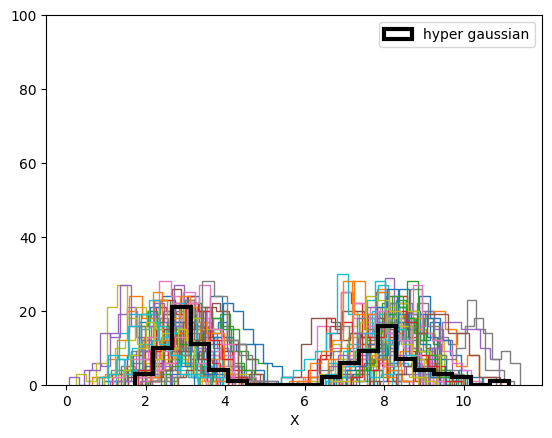

In [2]:
# True parameters for the parent + child Gaussian distribution

true_parent_mean_A = 3.0 # hyperparameter
true_parent_scale_A = .5 # hyperparameter
true_parent_mean_B = 8.0 # hyperparameter
true_parent_scale_B = .8 # hyperparameter

true_child_scale = 0.5

N_obs = 100
size_child = 100

# Hypothesis for parent gaussian 
## draws from parent  for mu child
true_parent_gaussian = np.hstack((np.random.normal(loc=true_parent_mean_A, scale=true_parent_scale_A, size=N_obs//2),
                            np.random.normal(loc=true_parent_mean_B, scale=true_parent_scale_B, size=N_obs//2)))

# Add scatter on the child mean because the data for a signal is signal + noise
err_on_mean_child = np.expand_dims(np.random.randn(N_obs)*true_child_scale, axis=1)
true_child_gaussian = np.random.normal(loc=true_parent_gaussian[:, np.newaxis] + err_on_mean_child, scale=true_child_scale, size=(N_obs, size_child))

for i in range(N_obs):
    plt.hist(true_child_gaussian[i], fill=False, histtype='step')
    # plt.vlines(np.mean(true_child_gaussian[i]), 0, size_child, linestyles='-.', alpha=0.3)
plt.hist(true_parent_gaussian, fill=False, histtype='step', color='black',linewidth=3, label='hyper gaussian', bins=20)
plt.xlabel("X")
plt.legend()
plt.ylim(0,size_child)

In [3]:
def log_hyperprior(params):
    parent_mean_A, parent_scale_A, parent_mean_B, parent_scale_B = params
    if (0 < parent_mean_A < 5 and 
        0 < parent_scale_A < 1 and
        5 < parent_mean_B < 10 and 
        0 < parent_scale_B < 1 and 
        parent_scale_A < parent_scale_B):
        return 0.0
    return -np.inf

def log_likelihood(params):
    parent_mean_A, parent_scale_A, parent_mean_B, parent_scale_B = params
    samples_mu_child = true_child_gaussian
    model = 0.5 * (2 * np.pi * parent_scale_A**2)**-.5 * np.exp(-(samples_mu_child - parent_mean_A)**2 / (2 * parent_scale_A**2)) + \
            0.5 * (2 * np.pi * parent_scale_B**2)**-.5 * np.exp(-(samples_mu_child - parent_mean_B)**2 / (2 * parent_scale_B**2))
    return np.log(np.prod(np.mean(model, axis=1)))

def log_probability(params):
    log_prior_val = log_hyperprior(params)
    if not np.isfinite(log_prior_val):
        return -np.inf
    return log_prior_val + log_likelihood(params)

In [4]:
import emcee

pos = np.array([true_parent_mean_A, 
                true_parent_scale_A, 
                true_parent_mean_B,
                true_parent_scale_B]) + 0.1 * np.random.randn(4) + 1e-6 * np.random.randn(30, 4)
nwalkers, ndim = pos.shape

print(pos.shape)

from multiprocessing import Pool

with Pool() as pool:
    sampler = emcee.EnsembleSampler(
        nwalkers, ndim, log_probability, pool=pool
    )
    sampler.run_mcmc(pos, 3000)

(30, 4)


/tmp/ipykernel_13508/4078792293.py:16: RuntimeWarning: divide by zero encountered in log
  return np.log(np.prod(np.mean(model, axis=1)))
/tmp/ipykernel_13508/4078792293.py:16: RuntimeWarning: divide by zero encountered in log
  return np.log(np.prod(np.mean(model, axis=1)))
/tmp/ipykernel_13508/4078792293.py:16: RuntimeWarning: divide by zero encountered in log
  return np.log(np.prod(np.mean(model, axis=1)))
/tmp/ipykernel_13508/4078792293.py:16: RuntimeWarning: divide by zero encountered in log
  return np.log(np.prod(np.mean(model, axis=1)))
/tmp/ipykernel_13508/4078792293.py:16: RuntimeWarning: divide by zero encountered in log
  return np.log(np.prod(np.mean(model, axis=1)))
/tmp/ipykernel_13508/4078792293.py:16: RuntimeWarning: divide by zero encountered in log
  return np.log(np.prod(np.mean(model, axis=1)))


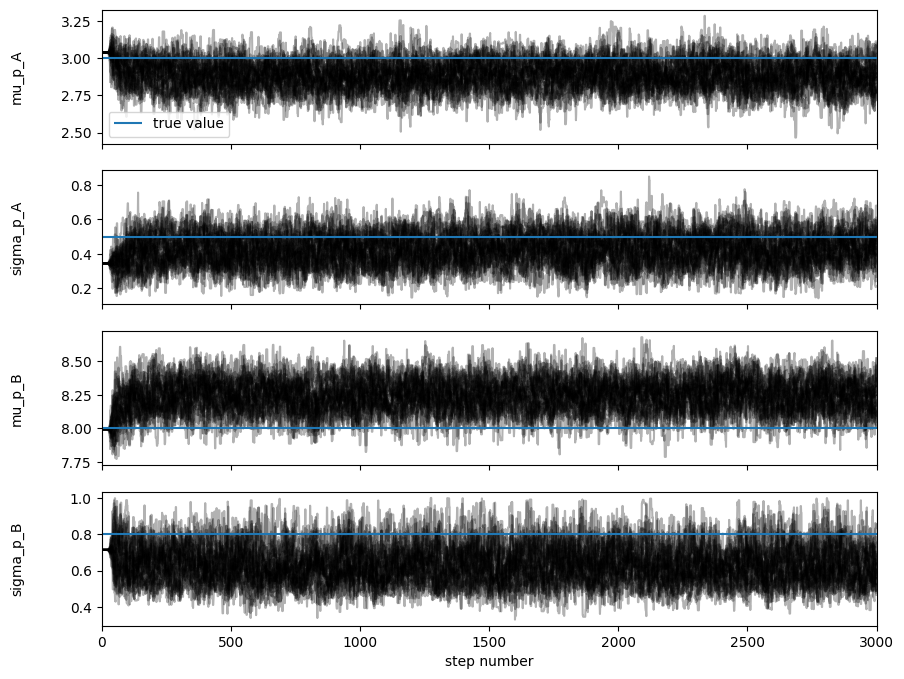

In [5]:
fig, axes = plt.subplots(4, figsize=(10, 8), sharex=True)
samples = sampler.get_chain()
labels = ["mu_p_A", "sigma_p_A", "mu_p_B", "sigma_p_B"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[0].hlines(true_parent_mean_A, 0, len(samples), label="true value")
axes[1].hlines(true_parent_scale_A, 0, len(samples))
axes[2].hlines(true_parent_mean_B, 0, len(samples))
axes[3].hlines(true_parent_scale_B, 0, len(samples))
axes[-1].set_xlabel("step number")
axes[0].legend()

In [6]:
tau = sampler.get_autocorr_time()
print(tau)

[42.5522202  46.16210232 49.00438275 48.04352268]


In [11]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

(5790, 4)


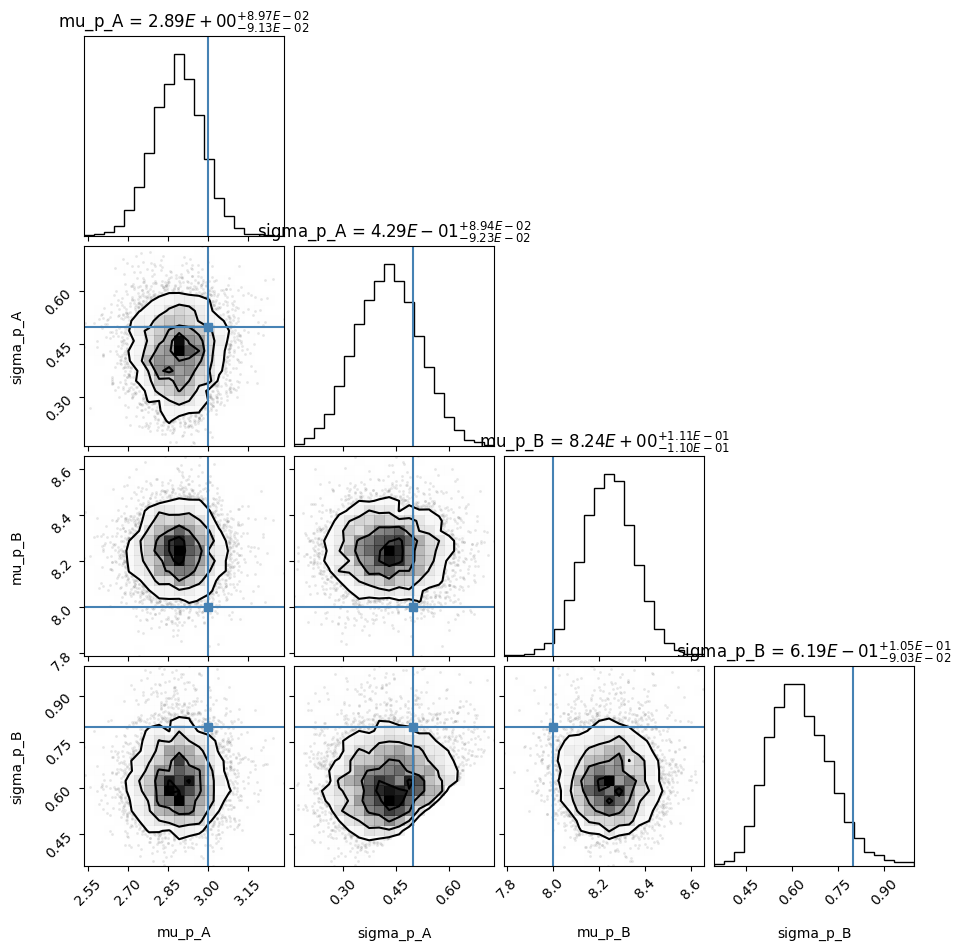

In [12]:
import corner

fig = corner.corner(
    flat_samples, labels=labels, truths=[true_parent_mean_A, 
                true_parent_scale_A, 
                true_parent_mean_B,
                true_parent_scale_B], title_fmt=".2E", show_titles=True, title_kwargs={'fontsize':12}
)